In [13]:
from pathlib import Path
import typing as T
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy
import xarray as xr
import iris
import iris.plot
import numpy as np
import os
import textwrap
import itertools
import ants
import warnings

In [14]:
home_dir=os.environ['HOME']
HOME=Path(home_dir)

In [15]:
# Find all regions for a given rose-id
ROSE ='u-dg767'
REGION_DIRS = [ d for d in list((HOME / 'cylc-run' / ROSE / 'share/data/ancils/' ).glob('*')) if d.is_dir() ]
REGION_DIRS                                                           

[PosixPath('/home/548/pag548/cylc-run/u-dg767/share/data/ancils/Gippsland')]

In [16]:
# Find all resolutions for a given REGION
for r_dir in REGION_DIRS:
    RESOLUTION_DIRS = [ d for d in list((r_dir).glob('*')) if d.is_dir() ]

In [17]:
RESOLUTION_DIRS

[PosixPath('/home/548/pag548/cylc-run/u-dg767/share/data/ancils/Gippsland/d1000'),
 PosixPath('/home/548/pag548/cylc-run/u-dg767/share/data/ancils/Gippsland/era5'),
 PosixPath('/home/548/pag548/cylc-run/u-dg767/share/data/ancils/Gippsland/d0198')]

Plotting land_binary_mask for d1000
Plotting land_binary_mask for era5
Plotting land_binary_mask for d0198


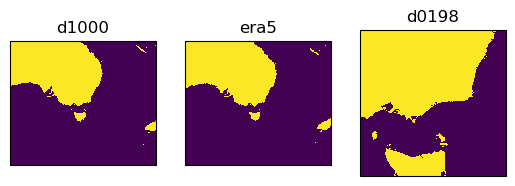

In [18]:
# quick check - plot and store land-sea masks for these resolutions
# Ignore warnings from mule  and iris 
warnings.filterwarnings('ignore',module='mule') 
warnings.filterwarnings('ignore',module='iris') 

num_plots = len(RESOLUTION_DIRS)

lsm_masks = {}

fig,ax = plt.subplots(1,num_plots,subplot_kw={'projection': ccrs.PlateCarree()})

for i,R in enumerate(RESOLUTION_DIRS):
    MASK_FILE = R / 'qrparm.mask'
    mask_cubes = ants.load(MASK_FILE)

    # Select the cube corresponding to 'land_binary_mask'
    lbm_cube, = [ cube for cube in mask_cubes if cube.name() == 'land_binary_mask'] 
    print (f'Plotting land_binary_mask for {R.name}')
    
    iris.plot.pcolormesh(lbm_cube,axes=ax[i])
    ax[i].set_title(f'{R.name}')

    # Store the masks for later analysis
    lsm_masks[R.name] = xr.DataArray.from_iris(lbm_cube)

In [19]:
# Now create dictionaries for all ancillary parameter files for each resolution
parm_files = {}

for i,R in enumerate(RESOLUTION_DIRS):
    
    all_files = list(R.glob('qrparm*'))

    # Filter out symlinks
    files = []
    [ files.append(f) for f in all_files if not f.is_symlink() ]

    parm_files[R.name] = files

In [66]:
# Get total list of fields for each resolution
num_plots = {}

# Loop over LAM resolutions
for res in parm_files.keys():

    count = 0
    # Loop over each ancillary parameter file for this resolution
    for file in parm_files[res]:
        #print (f'INFO : Loading {file}')
        try:
            cube = ants.load(file)
            #print (cube)
            count += len(cube)
        except:
            print (f'ERROR : Unable to open {file}\nERROR : You will have to manually check this file using "xconv" ')
            continue

    num_plots[res] = count
    print (f'There are {num_plots[res]} fields for {res}')
    

ERROR : Unable to open /home/548/pag548/cylc-run/u-dg767/share/data/ancils/Gippsland/d1000/qrparm.veg.dist
ERROR : You will have to manually check this file using "xconv" 
There are 71 fields for d1000
ERROR : Unable to open /home/548/pag548/cylc-run/u-dg767/share/data/ancils/Gippsland/era5/qrparm.veg.dist
ERROR : You will have to manually check this file using "xconv" 
There are 71 fields for era5
ERROR : Unable to open /home/548/pag548/cylc-run/u-dg767/share/data/ancils/Gippsland/d0198/qrparm.veg.dist
ERROR : You will have to manually check this file using "xconv" 
There are 71 fields for d0198


In [21]:
# Some logic to collapse multi-level cubes for simple plotting. It is assumed that any gross
# errors in the ancillaries (e.g. NaNs) will remain after the averaging

def collapse_cube(file,
                  cube):
    """
    Collapse a cube onto lat/lon dimensions via averaging
    """
    collapse_dims = []
    
    for coord in cube.coords():
        if coord not in cube.dim_coords:
            collapse_dims.append(coord.name())
            print (f'For {file.name} {cube.name()} coordinate {coord.name()} will be collapsed')
            
    # Check if time remains
    if 'time' in [ c.name() for c in cube.dim_coords ]: 
        collapse_dims.append('time')
        print (f'For {file.name} variable {cube.name()} coordinate time will be collapsed')
    new_cube = cube.collapsed(collapse_dims,iris.analysis.MEAN)

    return new_cube

In [22]:
# These ancillaries have a land-sea mask (i.e. ocean regions are already full of NaNs)
land_file_types = ['soil', 'veg', 'hydtop','MORUSES' ] 

In [63]:
# Set up diagnostic plotting for each resolution

def plot_ancils(region,
                files,
                num_plots,
                num_columns=4,
                lat_range=[],
                lon_range=[]):
    """
    Plot ancillaries fields for a given LAM resolution
    Check for the existence of NaNs and return these fields as a list
    of data_arrays
    """

    nan_fields = []
    
    num_rows = num_plots // num_columns
    
    if num_plots % num_columns != 0:
        num_rows += 1
    
    Position = range(1,num_plots+1)
    
    fig_height = num_rows*3
    fig_width = 15
    max_label_length=30

    print (f' Plotting ancillary parameters for {region}\n')
    
    fig = plt.figure(figsize=(fig_width,fig_height))
    k = 0
    
    # Loop over all ancillary files
    
    for file in files:
        try:
            cubes = ants.load(file)
        except:
            print (f'ERROR : Unable to open {file}')
            continue
    
        # Loop over all variables in cube
        for cube in cubes:
            ax = fig.add_subplot(num_rows, num_columns, Position[k])
    
            if len(cube.shape) > 2: 
                # Need to reduce dimension
                cube = collapse_cube(file,cube)
                
            da = xr.DataArray.from_iris(cube)
    
            # Find NaNs
            all_mask = da.isnull()
            
            # Check if this ancillary already has a land-sea mask
            if any(t in str(file) for t in land_file_types):
                # Remove the ocean from the NaN search
                all_mask = lsm_masks[region] & da.isnull()
        
            if all_mask.compute().sum() > 0:   
                print (f'ERROR : NaNs identified in {cube.name()},{file.name}')
                nan_fields.append(da)
            
            if 'standard_name' in da.attrs.keys():
                split = textwrap.wrap(da.attrs['standard_name'].replace('_',' '),max_label_length)
                label = '\n'.join(split)
                cb_args = {'label': label}
            else:
                cb_args = {'label':da.attrs['STASH']}

            # Plot according to specified lat/lon ranges
            if lat_range and lon_range:
                da.sel(latitude=slice(lat_range[0],lat_range[1]),
                       longitude=slice(lon_range[0],lon_range[1]))\
                       .plot(ax=ax,cbar_kwargs=cb_args)
            elif lat_range:
                da.sel(latitude=slice(lat_range[0],lat_range[1]))\
                       .plot(ax=ax,cbar_kwargs=cb_args)
            elif lon_range:
                da.sel(longitude=slice(lon_range[0],lon_range[1]))\
                       .plot(ax=ax,cbar_kwargs=cb_args)
            else:
                da.plot(ax=ax,cbar_kwargs=cb_args)
            ax.set_title(file.name)
            k += 1

    fig.suptitle(f'Ancillary parameter fields for {region}',fontsize=20,y=1.0)
    plt.tight_layout()

    return nan_fields

 Plotting ancillary parameters for d1000

For qrparm.veg.func_igbp canopy_height coordinate pseudo_level will be collapsed
For qrparm.veg.func_igbp canopy_height coordinate month will be collapsed
For qrparm.veg.func_igbp leaf_area_index coordinate pseudo_level will be collapsed
For qrparm.veg.func_igbp leaf_area_index coordinate month will be collapsed
For qrparm.veg.func canopy_height coordinate pseudo_level will be collapsed
For qrparm.veg.func variable canopy_height coordinate time will be collapsed
ERROR : NaNs identified in canopy_height,qrparm.veg.func
For qrparm.veg.func leaf_area_index coordinate pseudo_level will be collapsed
For qrparm.veg.func variable leaf_area_index coordinate time will be collapsed
ERROR : Unable to open /home/548/pag548/cylc-run/u-dg767/share/data/ancils/Gippsland/d1000/qrparm.veg.dist
For qrparm.veg.frac.urb2t m01s00i216 coordinate pseudo_level will be collapsed
For qrparm.veg.frac_igbp m01s00i216 coordinate pseudo_level will be collapsed
For qrparm.ve

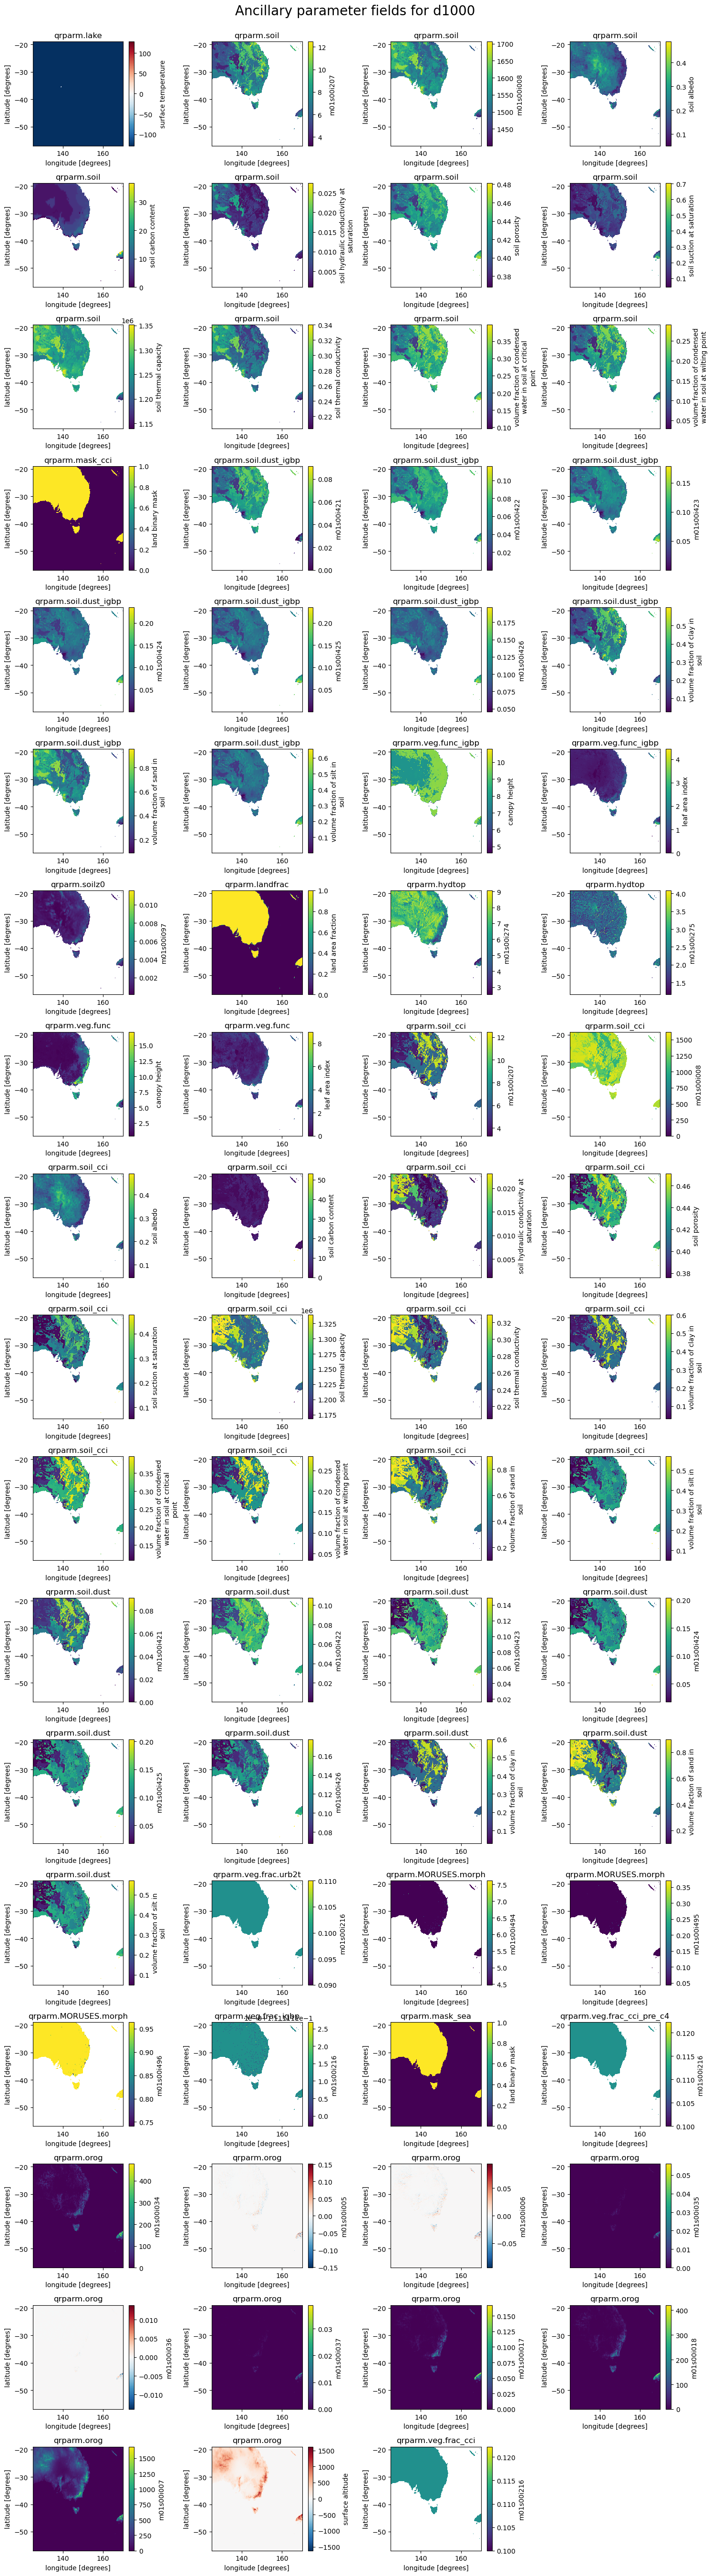

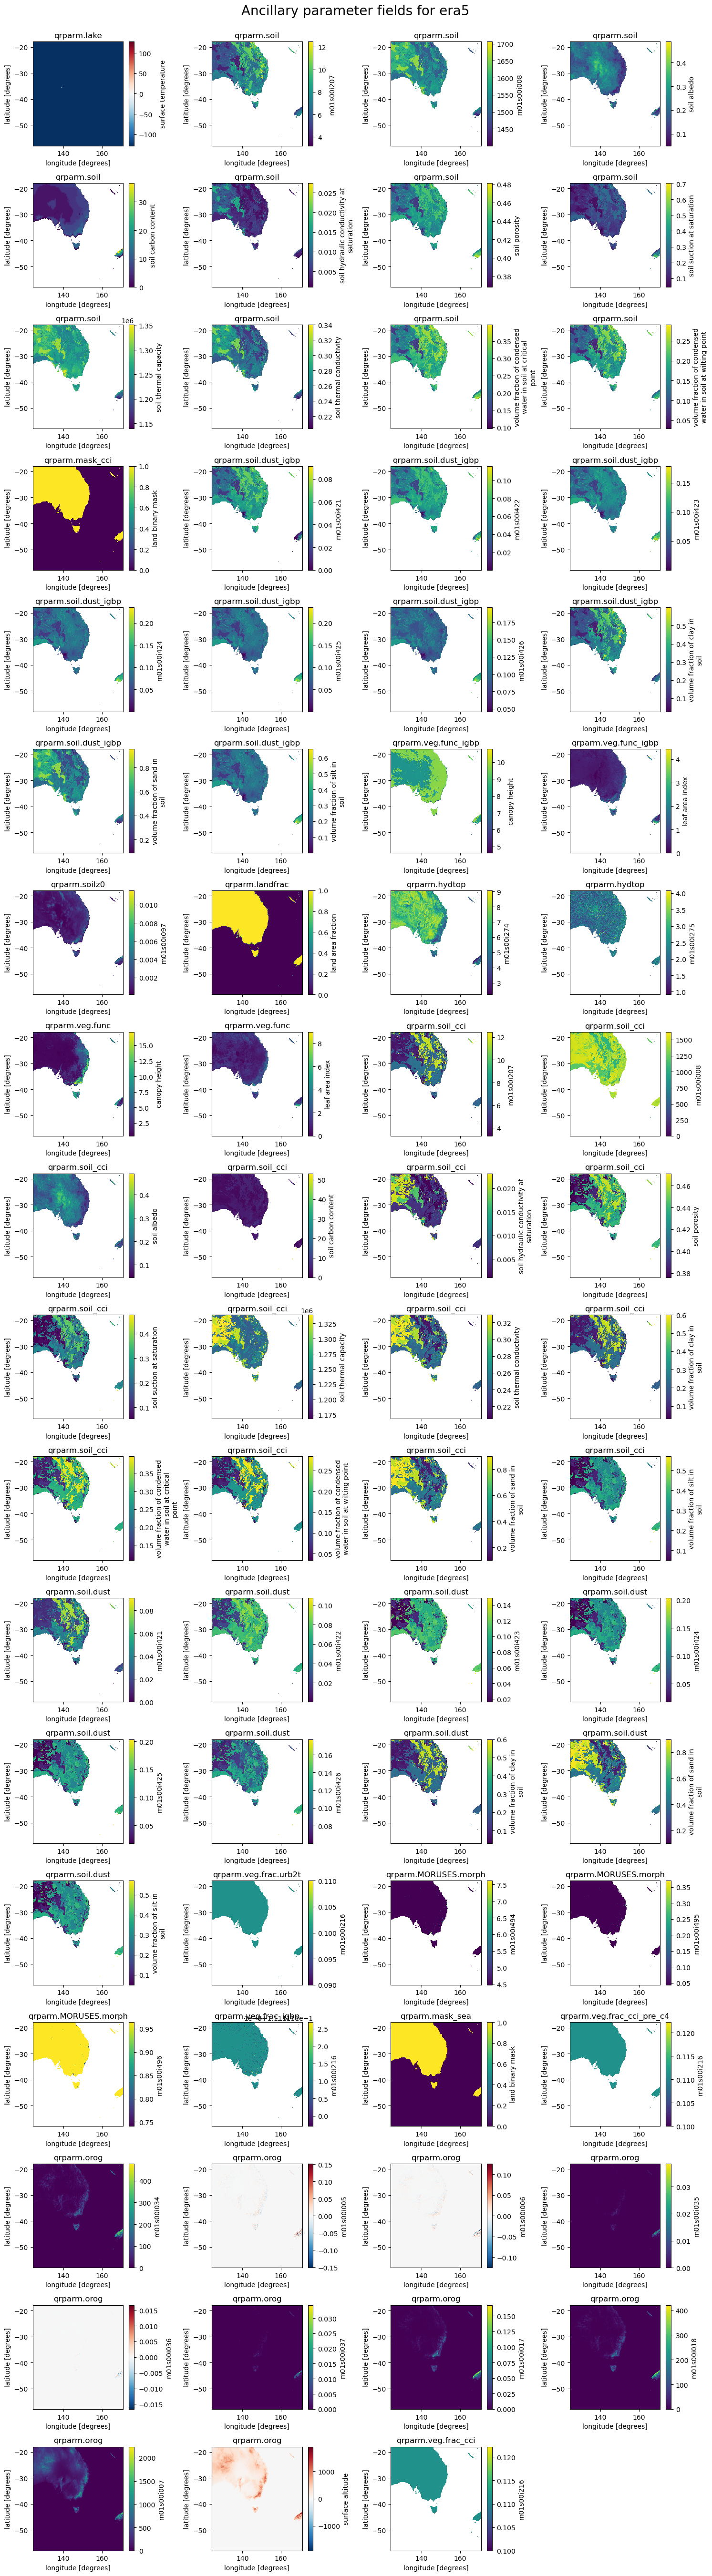

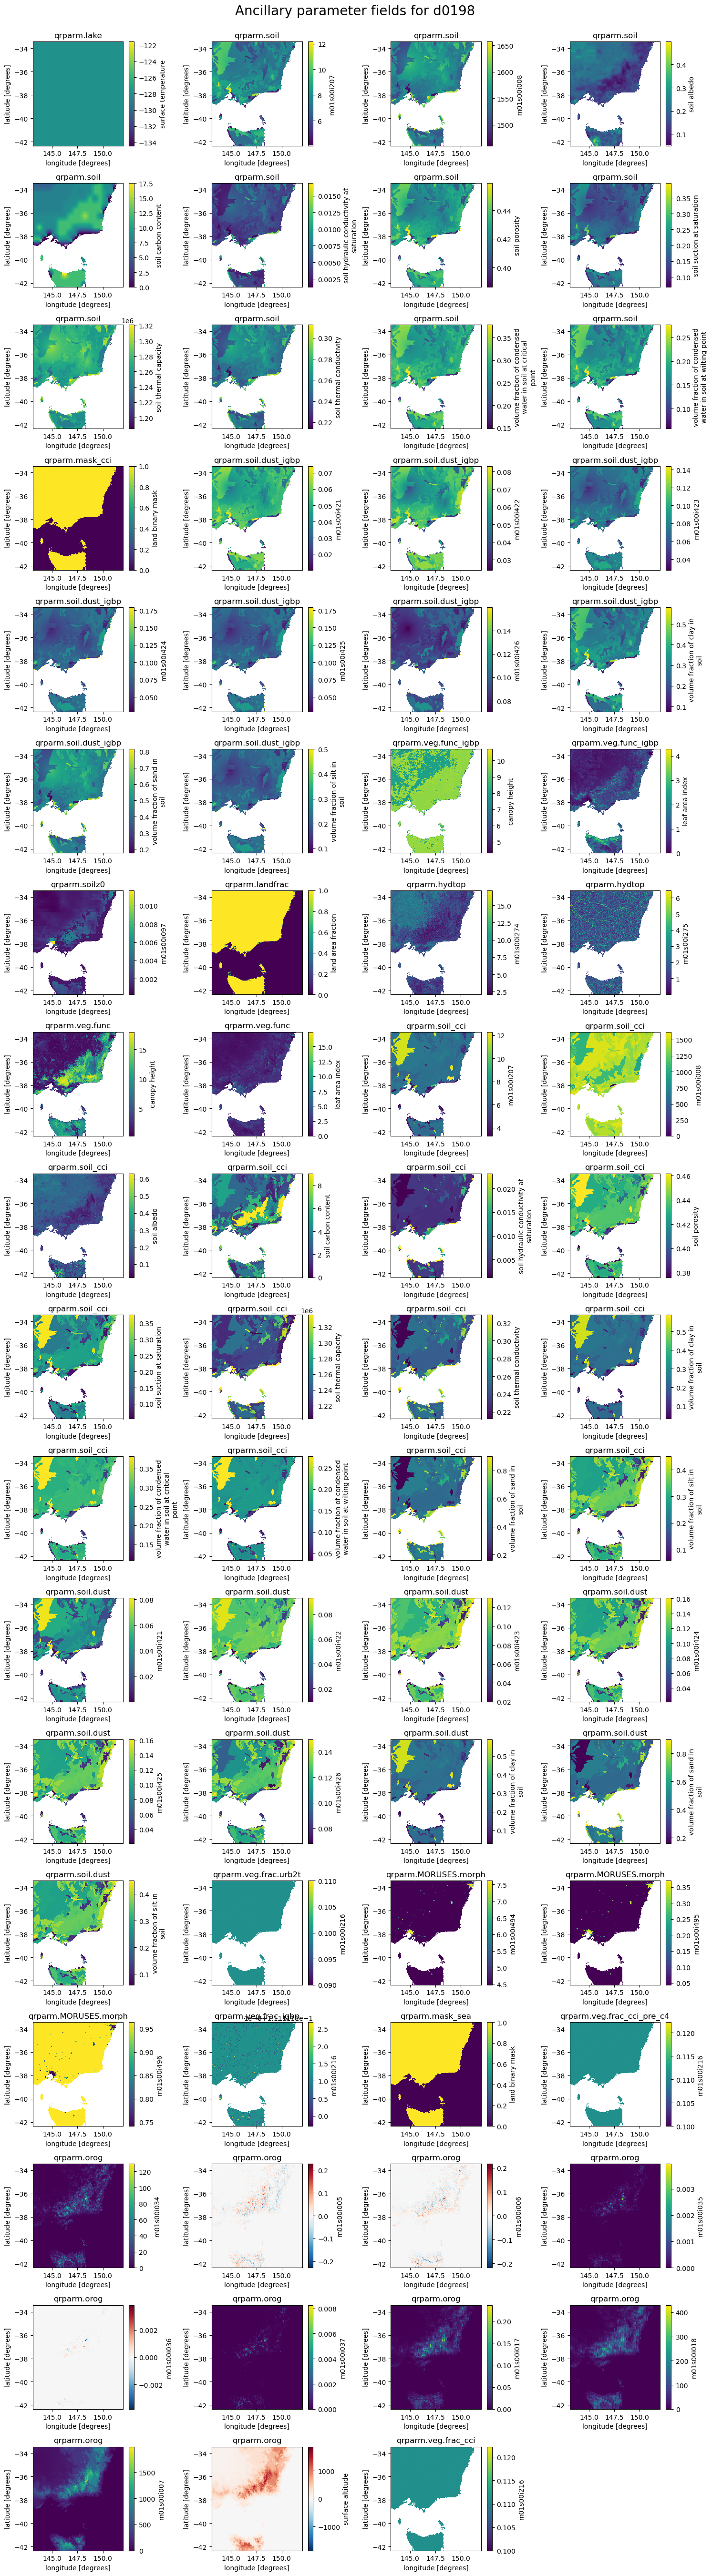

In [26]:
# Now plot for all resolutions and catch ancillary parameter fields with NaNs
bad_ancils = []

# Loop over all resolutions
for res in parm_files.keys():
    nan_ancils = plot_ancils(res,
                             parm_files[res],
                             num_plots[res])

    bad_ancils.extend(nan_ancils)

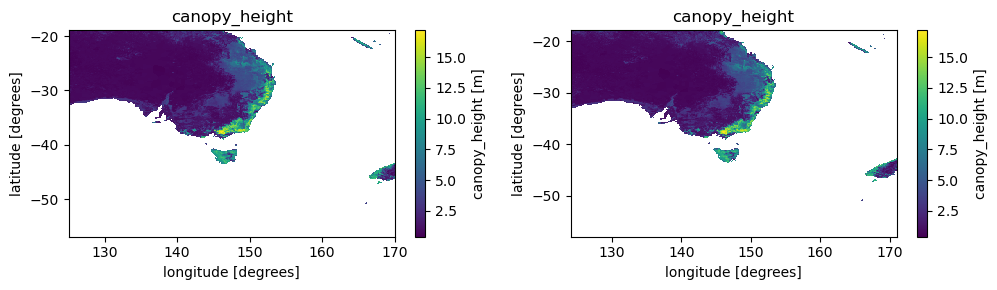

In [68]:
# Now plot the bad_ancils
num_plot=len(bad_ancils)
num_columns=3
num_rows = num_plot // num_columns

if num_plot % num_columns != 0:
    num_rows += 1

Position = range(1,num_plot+1)

fig_height = num_rows*3
fig_width = 15
max_label_length=30

fig = plt.figure(figsize=(fig_width,fig_height))

k = 0

for k in range(num_plot):
     ax = fig.add_subplot(num_rows, num_columns, Position[k])
     da = bad_ancils[k]
     da.plot(ax=ax)
     ax.set_title(f'{da.name}')
plt.tight_layout()

In [40]:
# Zoom in on NaNs. Let's do this manually for region era5
# These ancils have a land-sea mask so we need to extract that
da = bad_ancils[0]
mask = lsm_masks['era5']

all_mask = mask & da.isnull()

# Find location of NaNs
all_mask.compute()
all_mask.where(all_mask.compute()==True,drop=True).compute()

<xarray.DataArray (latitude: 3, longitude: 2)> Size: 48B
array([[ 1., nan],
       [ 1., nan],
       [nan,  1.]])
Coordinates:
  * latitude      (latitude) float32 12B -54.68 -54.58 -52.58
  * longitude     (longitude) float32 8B 158.9 169.2
    pseudo_level  int64 8B 3
    time          datetime64[ns] 8B 2005-07-02T12:00:00

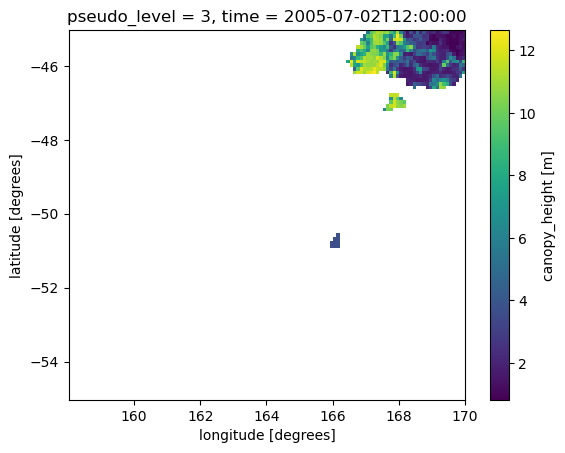

In [51]:
# OK, so we seem to have three points of NaN located b/w lat -54.7 to -52.6
# lat 158.9 to 169.2
da.sel(latitude=slice(-55,-45),longitude=slice(158,170)).plot()


In [56]:
# So we are in the Southern Ocean. Let's plot the bad points
points = all_mask.where(all_mask.compute()==True,drop=True).compute()

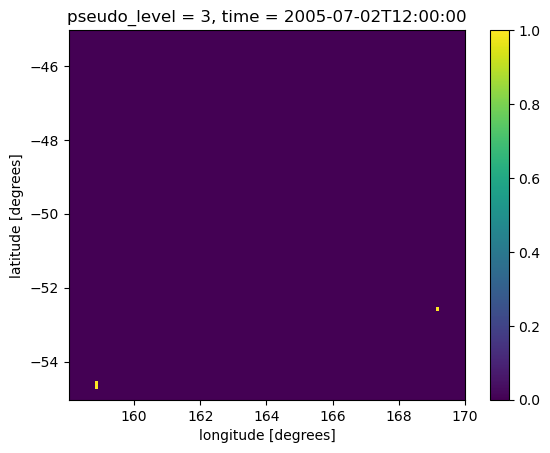

In [53]:
all_mask.sel(latitude=slice(-55,-45),longitude=slice(158,170)).plot()

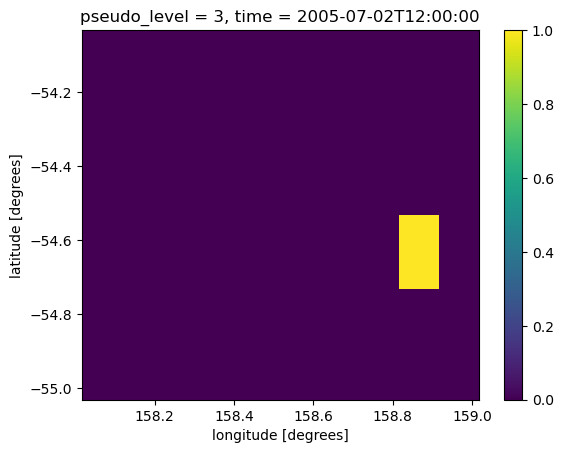

In [72]:
# These points appear to be associated with Macquarie Island and Campbell Island.
# Let's plot all the ERA5 ancillaries around Macquarie Island.
all_mask.sel(latitude=slice(-55,-54),longitude=slice(158,159)).plot()

 Plotting ancillary parameters for era5

For qrparm.veg.func_igbp canopy_height coordinate pseudo_level will be collapsed
For qrparm.veg.func_igbp canopy_height coordinate month will be collapsed
For qrparm.veg.func_igbp leaf_area_index coordinate pseudo_level will be collapsed
For qrparm.veg.func_igbp leaf_area_index coordinate month will be collapsed
For qrparm.veg.func canopy_height coordinate pseudo_level will be collapsed
For qrparm.veg.func variable canopy_height coordinate time will be collapsed
ERROR : NaNs identified in canopy_height,qrparm.veg.func
For qrparm.veg.func leaf_area_index coordinate pseudo_level will be collapsed
For qrparm.veg.func variable leaf_area_index coordinate time will be collapsed
ERROR : Unable to open /home/548/pag548/cylc-run/u-dg767/share/data/ancils/Gippsland/era5/qrparm.veg.dist
For qrparm.veg.frac.urb2t m01s00i216 coordinate pseudo_level will be collapsed
For qrparm.veg.frac_igbp m01s00i216 coordinate pseudo_level will be collapsed
For qrparm.veg.

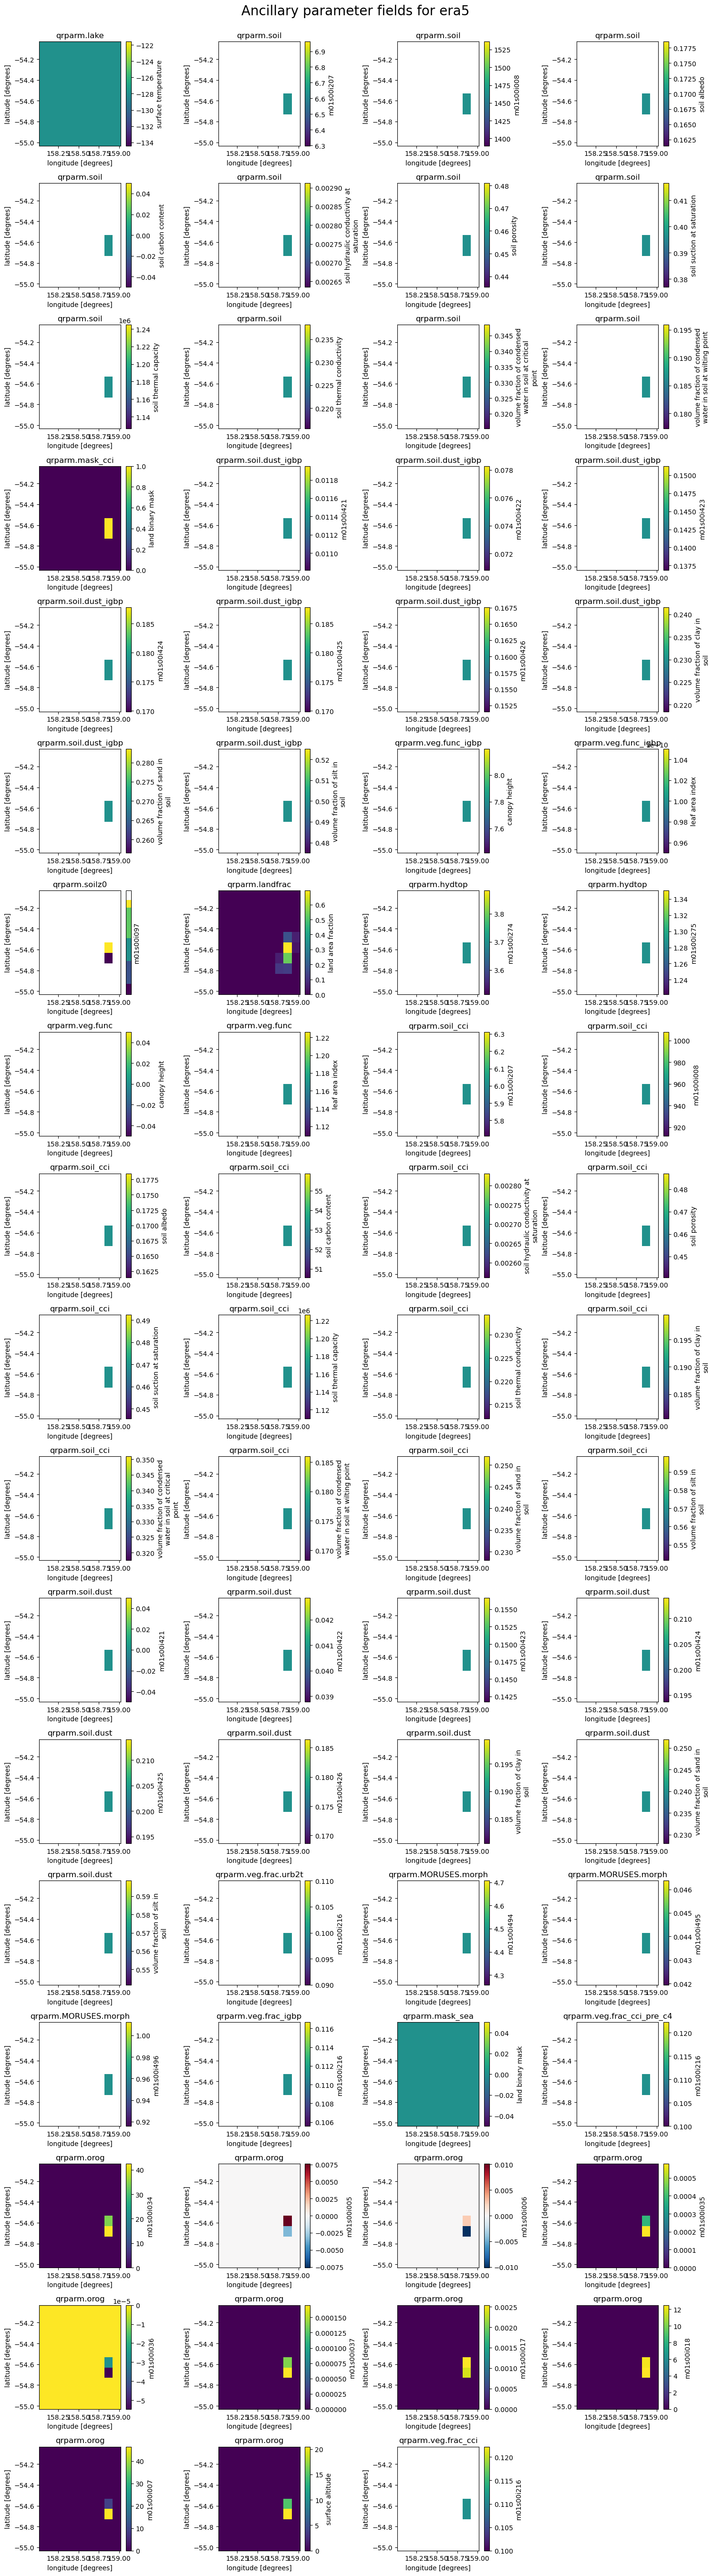

In [73]:
res='era5'
nan_ancils = plot_ancils(res,
                         parm_files[res],
                         num_plots[res],
                         lat_range=[-55,-54],
                         lon_range=[158,159])

In [86]:
# OK. So Macquarie Island is resolved at this resolution for all ancillaries except canopy height.
#  And the island is resolved by qrparm.mask_cci (which is the file used by the UM).
#  The island isn't resolved by qrparm.mask_sea however.
# Let's use the method suggested by Matthew Lipson : https://forum.access-hive.org.au/t/aus2200-vegetation-fraction-ancil-creation-issues/1972/13?u=paul.gregory
veg_func_file, = [ f for f in parm_files['era5'] if f.name == 'qrparm.veg.func' ]
lsm_mask_file,  = [ f for f in parm_files['era5'] if f.name == 'qrparm.mask_cci' ]

In [ ]:
veg_cube = ants.load(veg_func_file)[0]
lsm_cube = ants.load(lsm_mask_file)[0]

# The ants code can only handle 3-d cubes, so we have to pass each level of the canopy height as a separate call.
for level in range(1,6):
    canopy_level = iris.Constraint(pseudo_level=level)
    ants.analysis.make_consistent_with_lsm(veg_cube.extract(canopy_level),lsm_cube,invert_mask=False)

In [ ]:
veg_cube.coords()

In [ ]:
level = iris.Constraint(pseudo_level=1)
veg_cube.extract(level)

In [ ]:
a = ants.analysis.make_consistent_with_lsm(veg_cube.extract(level),lsm_cube,invert_mask=True)

In [ ]:
# Check if a is 'fixed'
da_a = xr.DataArray.from_iris(veg_cube.extract(level))
da_a[0].sel(latitude=slice(-55,-54),longitude=slice(158,159)).plot()

In [120]:
# Lets work out what this does https://code.metoffice.gov.uk/doc/ancil/ants/0.16/_modules/ants/analysis.html#make_consistent_with_lsm
lsm=lsm_cube
sources = veg_cube.extract(canopy_level)
invert_mask=True
mask = lsm.copy(lsm.data.astype("bool", copy=False))
                
if ants.utils.cube._is_ugrid(mask) is False:
    ants.utils.cube.guess_horizontal_bounds(mask)
if invert_mask:
    mask.data = np.logical_not(mask.data)

sources = ants.utils.cube.as_cubelist(sources)

for cube in sources:
    if ants.utils.cube._is_ugrid(cube): # This False for our case
        Filler = ants.analysis._UGridFillMissingPoints
    else:
        Filler = ants.analysis.FillMissingPoints 
        ants.utils.cube.guess_horizontal_bounds(cube)
    filler = Filler(cube, target_mask=mask)
    filler(cube)

In [124]:
ants.utils.cube._is_ugrid(cube)

False

In [117]:
veg_cube.extract(canopy_level)

<iris 'Cube' of canopy_height / (m) (time: 12; latitude: 400; longitude: 470)>

In [ ]:
cube[0].name()

In [ ]:
# Now search for nans outside land sea mask
fig = plt.figure(figsize=(fig_width,fig_height))
k = 0
for file in files:
    try:
        cubes = ants.load(file)
    except:
        print (f'ERROR : Unable to open {file}')
        continue

    # Loop over all variables in cube
    for cube in cubes:
        ax = fig.add_subplot(num_rows, num_columns, Position[k])

        if len(cube.shape) > 2: 
            # Need to reduce dimension
            cube = collapse_cube(file,cube)
            
        da = xr.DataArray.from_iris(cube)
        if 'standard_name' in da.attrs.keys():
            split = textwrap.wrap(da.attrs['standard_name'].replace('_',' '),max_label_length)
            label = '\n'.join(split)
            cb_args = {'label': label}
        else:
            cb_args = {'label':da.attrs['STASH']}

        # Search for nans outside land/sea mask
        nan_mask = (da.isnull()  & sea_mask)
        unique = np.unique(da.where(~nan_mask).values)
        if np.isnan(unique).any():
            print (f'{cube.name()} has NaNs on land')
            da.plot(ax=ax,cbar_kwargs=cb_args)
            ax.set_title(file.name)
            k += 1

plt.tight_layout()

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(15,4))
sea_mask.plot(ax=ax[0])
da.plot(ax=ax[1])
nan_mask = (da.isnull()  & sea_mask)
nan_mask.plot(ax=ax[2])
plt.tight_layout()

In [ ]:
unique = np.unique(da.where(~nan_mask).values)
unique

In [ ]:
da.where(~sea_mask).plot()

In [ ]:
# Ok let's fix this properly by looking at at small slice near Port Phillip Bay
